# Лаба 2

**Дедлайн**: 25 ноября

**Задача**: написать определитель тональности текста (сообщениея в Twitter) c помощью fine-tuning-а на датасете RuSentiTweet (https://github.com/sismetanin/rusentitweet)

На что обратить внимание:
(+)Подготовка данных (очистка, токенизация и упаковка датасета в удобный класс) - у вас в задании другой датасет, соответственно обработка может поменяться. В датасете несколько файлов, скачайте rusentitweet_full.csv и работайте с ним
(-)Процедура дообучения. Вам необходимо доработать имеющуюся процедуру:
    --(-) Добавить графики качества обучения модели в зависимости от шага (делать валидацию каждые 100 шагов (например), а не раз в эпоху)
    --(+) Замерить время обучения
    --(-) Добавить больше метрик для отслеживания (изучите по открытым источникам, какие метрики используются для задачи определения тональности и почему)
    --(-) Добавить заморозку части слоев (все, кроме слоя классификации, или кроме слоя классификации + 2-3 последних слоев с интентами)
    --(-) Подобрать количество эпох, размер батча и заморозку так, чтобы модель давала лучший результат
(-)Модель для дообучения (попробуйте как минимум 2 разных модели), искать подходящие модели можно с помощью гугла и https://huggingface.co/
(+)Результаты **всех** экспериментов должны быть описаны в отдельной ячейке
(+)Inference модели - обученную модель нужно обернуть в удобную функцию для использования, которая по тексту будет возвращать его тональность


https://www.youtube.com/watch?v=xI0HHN5XKDo

## Импорты

In [42]:
import typing, re, torch, os.path, sys, emot, torchmetrics

from torch.utils.data.dataset import T_co

# костыль, чтоб общий файлик сгрузить
if not sys.path.__contains__('..'):
    sys.path.insert(0, '..')
import helper

from num2words import num2words
from cleantext import clean
from pathlib import Path

from torch.utils.data import TensorDataset, DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

emot_core = emot.core.emot()

In [39]:
import importlib

importlib.reload(helper)

<module 'helper' from 'C:\\Users\\anast3t\\Desktop\\all\\coding\\neural-networks\\Task2\\..\\helper.py'>

## Константы

In [3]:
SEED = 42
BATCH_SIZE = 32
SPLIT_SIZE = 0.3
NUM_WORKERS = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

## Очистка данных

Разберемся с данными - уберем ненужные колонки, символы и т.д.

In [4]:
# Как всегда - на все случаи жизни есть библиотечки.
# Однако зачем-то я решил настолько очисткой заморочиться, что даже эмотиконы вытащил, и вот на это библиотек не было

def num2words_with_extract(text: typing.AnyStr) -> typing.AnyStr:
    split_text = text.split(' ')
    for idx, segment in enumerate(split_text):
        if segment.isdigit():
            split_text[idx] = num2words(segment, lang='ru')
    return " ".join(split_text)


def remove_emoticons(text: typing.AnyStr, emot_core) -> typing.AnyStr:  # TODO: write your own emoticon regexp
    res = emot_core.emoticons(text)
    for emoticon in res['value']:
        # print(emoticon)
        regex = '(?:'
        for symbol in [*emoticon]:
            regex += (symbol if symbol.isalpha() or symbol.isdigit() else '\\' + symbol) + '+'
        regex += ')'
        # print(regex)
        compiled = re.compile(regex)
        text = compiled.sub(r'', text)
    return text


def clean_text(text: typing.AnyStr, emot_core=emot_core) -> typing.AnyStr:
    text = clean(
        text=text,
        fix_unicode=False,  # fix various unicode errors
        to_ascii=False,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_emoji=True,
        no_numbers=False,  # replace all numbers with a special token
        no_digits=False,  # replace all digits with a special token
        no_currency_symbols=False,  # replace all currency symbols with a special token
        no_punct=False,  # remove punctuations
        normalize_whitespace=True,
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        # lang="en"                       # set to 'de' for German special handling
    )
    tag_pattern = re.compile("@\S+")
    dot_pattern = re.compile("\.{2,}")
    text = tag_pattern.sub(r'', text)  # убираем теги юзеров
    text = dot_pattern.sub(r'', text)  # убираем многоточия (на всякий случай, тк их много)
    text = remove_emoticons(text, emot_core)  # убираем эмотиконы типа :) :-(((
    text = num2words_with_extract(text)  # преобразуем цифры в текст
    return " ".join(text.split())  # normalize whitespaces


# пример отработки
clean_text(
    "@varlamov @McFa__ul bortnikov@mail.ru На Ой какие неожиданные ::-( :333 100 .......... результаты 🤭 https://t.co/ZwOHPDKUqq 88005553535",
    emot_core)

'на ой какие неожиданные сто результаты'

In [5]:
twitter_cut = None
csv_path = Path("csv")
twitter_full_path = csv_path / "twitter_full.csv"
twitter_cut_path = csv_path / "twitter_cut.pickle"

twitter = pd.read_csv(twitter_full_path)

if not os.path.exists(twitter_cut_path):
    print("Clearing initial csv and saving to pickle")
    twitter_cut = twitter.drop(["id", "Unnamed: 0"], inplace=False, axis=1)  # .rename(columns={"Unnamed: 0": "index"})
    twitter_cut = twitter_cut[twitter_cut["label"] != "skip"]
    twitter_cut = twitter_cut.reset_index()
    twitter_cut.rename(columns={"index": "old_idx"}, inplace=True)
    twitter_cut["text_clean"] = twitter_cut["text"].apply(clean_text)
    twitter_cut.to_pickle(twitter_cut_path)
else:
    print("Loading existing pickle")
    twitter_cut = pd.read_pickle("./csv/twitter_cut.pickle")


Loading existing pickle


In [6]:
# twitter.head(10)

In [7]:
twitter_cut.head(100)

,old_idx,text,label,text_clean
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина
...,...,...,...,...
95,110,@snakey_ssnake Делать еще ╰(‵□′)╯ (мне понрави...,positive,делать еще ╰(‵□′)╯ (мне понравилось)
96,112,@cerealporridge 😭😭😭😭♥️♥️♥️♥️ спасибо 😭♥️♥️♥️♥️,speech,спасибо
97,114,В СевГУ прошел круглый стол по случаю Дня соли...,neutral,в севгу прошел круглый стол по случаю дня соли...
98,115,"@great_knee Бро,моя тоже",neutral,"бро,моя тоже"


In [8]:
def label_to_int(label):
    if label == 'negative':
        return 0
    elif label == 'neutral' or label == 'speech':
        return 1
    elif label == 'positive':
        return 2


twitter_cut["num_label"] = twitter_cut["label"].apply(label_to_int)

twitter_cut

,old_idx,text,label,text_clean,num_label
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1
...,...,...,...,...,...
11544,13386,Это просто промокод и он одноразовый! https://...,neutral,это просто промокод и он одноразовый!,1
11545,13387,все пора спать пиздец словила шизу,negative,все пора спать пиздец словила шизу,0
11546,13388,такими темпами я создам новую секту или органи...,neutral,такими темпами я создам новую секту или органи...,1
11547,13389,"Ты смотрела аниме, завернувшись в одеяло ,пока...",neutral,"ты смотрела аниме, завернувшись в одеяло ,пока...",1


[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

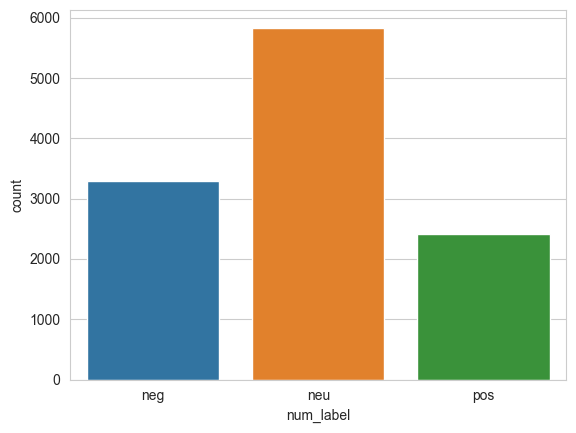

In [9]:
ax = sns.countplot(data=twitter_cut, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

Из-за того, что speech ушел в neutral, то у нас возникает дисбаланс (возможно с этим стоило что-то сделать)

## Высокоуровневая предобработка

Сначала попробуем дистиллированную модель https://habr.com/ru/articles/562064/

In [10]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path="cointegrated/rubert-tiny")

In [11]:
def tokenize(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return pd.Series([encoding["input_ids"], encoding["attention_mask"]])

Вроде как можно написать кастомный класс датасета, но вроде как можно и не писать, так и не понял пока

In [12]:
twitter_cut[["input_ids", "attention_mask"]] = twitter_cut["text_clean"].apply(tokenize)

Разделяем на трейн/тест

In [13]:
train_df, test_df = train_test_split(
    twitter_cut,
    test_size=SPLIT_SIZE,
    shuffle=True,
    stratify=twitter_cut['num_label'].values,
    random_state=SEED
)

train_dataset = TensorDataset(torch.cat(list(train_df["input_ids"].values), dim=0),
                              torch.cat(list(train_df["attention_mask"].values), dim=0),
                              torch.tensor(train_df["num_label"].values))

test_dataset = TensorDataset(torch.cat(list(test_df["input_ids"].values), dim=0),
                             torch.cat(list(test_df["attention_mask"].values), dim=0),
                             torch.tensor(test_df["num_label"].values))

# Prepare DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True
)

## Кидаем все это в модель

In [41]:


# Заметка для себя - параметры тут https://huggingface.co/transformers/v2.9.1/main_classes/configuration.html

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "rubert_tiny.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

RES_PATH = Path("model_res")
RES_PATH.mkdir(parents=True,
               exist_ok=True)
RES_NAME = "rubert_tiny.pickle"
RES_SAVE_PATH = RES_PATH / RES_NAME


rubert_tiny = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="cointegrated/rubert-tiny",
    num_labels = 3
).to(device)

rubert_tiny.name = "rubert_tiny"

loss_fn = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.AdamW(
    rubert_tiny.parameters(),
    lr = 8e-5,
    eps = 1e-08
)

f1 = torchmetrics.F1Score(
    task="multiclass",
    num_classes=3,
    device=device
).to(device)

rubert_tiny_results = None

if os.path.exists(RES_SAVE_PATH) and os.path.exists(MODEL_SAVE_PATH):
    print("Loading existing model")
    rubert_tiny.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
    rubert_tiny_results = pd.read_pickle(RES_SAVE_PATH)
else:
    rubert_tiny_results = helper.model_trainer(
        model=rubert_tiny,
        epochs=15,
        test_dataloader=test_dataloader,
        train_dataloader=train_dataloader,
        loss_function=loss_fn,
        optimizer=optimizer,
        eval_function=f1,
        device=device,
        transformer=True
        # scheduler=torch.optim.lr_scheduler.ExponentialLR(
        #     optimizer=optimizer,
        #     gamma=0.75,
        #     verbose=True
        # ),
    )
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=rubert_tiny.state_dict(),
               f=MODEL_SAVE_PATH)
    rubert_tiny_results = pd.DataFrame([rubert_tiny_results])
    rubert_tiny_results.to_pickle(RES_SAVE_PATH)



Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

---------------------
Iterating on rubert_tiny, LR = 8e-05


Epochs of rubert_tiny:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 60.94120788574219
Loss: 0.8640542030334473



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 66.26210021972656
Loss: 0.7735646963119507

Epoch 2
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 70.9387435913086
Loss: 0.6826840043067932



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 66.20476531982422
Loss: 0.7755575180053711

Epoch 3
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 78.55237579345703
Loss: 0.5444914102554321



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 65.4880142211914
Loss: 0.8554880023002625

Epoch 4
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 84.34782409667969
Loss: 0.4109398126602173



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 65.91806030273438
Loss: 0.9651371836662292

Epoch 5
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 89.51087188720703
Loss: 0.30451613664627075



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 65.4880142211914
Loss: 1.1345665454864502

Epoch 6
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 91.27717590332031
Loss: 0.24205060303211212



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 66.04867553710938
Loss: 1.2299654483795166

Epoch 7
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 94.12303161621094
Loss: 0.17349094152450562



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 64.64385986328125
Loss: 1.3543148040771484

Epoch 8
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 95.66946411132812
Loss: 0.13067370653152466



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 64.11505126953125
Loss: 1.4469952583312988

Epoch 9
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 95.9708480834961
Loss: 0.11740028858184814



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 63.283634185791016
Loss: 1.5884788036346436

Epoch 10
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 96.75643157958984
Loss: 0.09903057664632797



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 63.68501281738281
Loss: 1.6442402601242065

Epoch 11
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 97.44318389892578
Loss: 0.07767719775438309



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 62.19418716430664
Loss: 1.8907814025878906

Epoch 12
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 97.28755187988281
Loss: 0.08096694201231003



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 62.19418716430664
Loss: 1.8272005319595337

Epoch 13
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 97.90019989013672
Loss: 0.0639488473534584



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 62.79624557495117
Loss: 1.84959077835083

Epoch 14
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 97.90019989013672
Loss: 0.05882510915398598



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 63.11161422729492
Loss: 1.8678385019302368

Epoch 15
-------


Train batches:   0%|          | 0/253 [00:00<?, ?it/s]

---Train--- 
MulticlassF1Score: 98.19664001464844
Loss: 0.0523776151239872



Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

---Test--- 
MulticlassF1Score: 61.94890213012695
Loss: 1.9633963108062744

Total time on cuda: 76.529 seconds
Saving model to: models\rubert_tiny.pth


Как можно заметить - самому ни слои замораживать, ни добавлять слои не пришлось, на выходе 3 фичи
(что конечно с условием задачи не вписывается, поэтому далее буду на голом берте морозить слои)

Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.52      0.72      0.60       990
     neutral       0.71      0.65      0.68      1751
    positive       0.60      0.42      0.49       724

    accuracy                           0.62      3465
   macro avg       0.61      0.59      0.59      3465
weighted avg       0.63      0.62      0.62      3465



C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset[2])


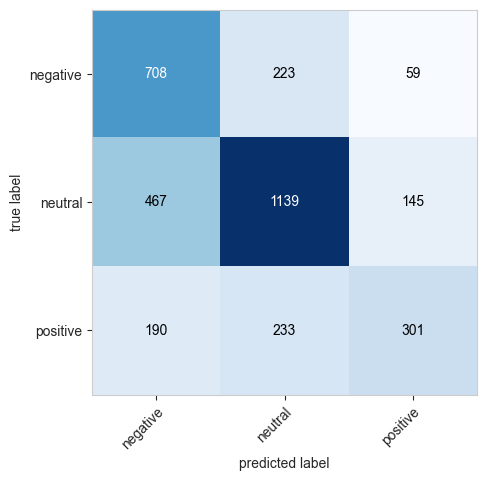

In [60]:
class_names = ["negative", "neutral", "positive"]

helper.model_eval_report(
    model=rubert_tiny,
    test_dataloader=test_dataloader,
    test_dataset=test_dataset,
    loss_function=loss_fn,
    eval_function=f1,
    device=device,
    transformer=True,
    class_names=class_names
)



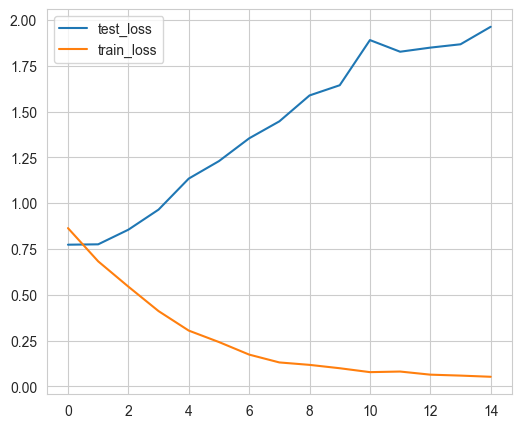

In [43]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(rubert_tiny_results.history_test_loss[0], label='test_loss')
plt.plot(rubert_tiny_results.history_train_loss[0], label='train_loss')
plt.legend()

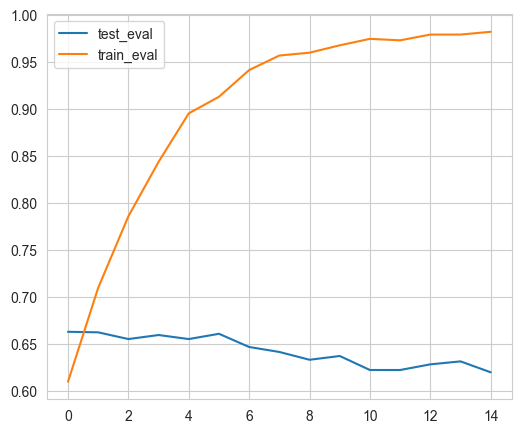

In [45]:
plt.rcParams['figure.figsize'] = [6, 5]
plt.plot(rubert_tiny_results.history_test_eval[0], label='test_eval')
plt.plot(rubert_tiny_results.history_train_eval[0], label='train_eval')
plt.legend()

Наблюдаем очевиднейший оверфит?....

In [104]:
def predict(text, model=rubert_tiny):
    model.eval()
    with torch.inference_mode():
        text = clean_text(text)
        print(text)
        tokenized = tokenize(text)
        tokenized[0] = tokenized[0].to(device)
        tokenized[1] = tokenized[1].to(device)
        evaluated = model(tokenized[0], token_type_ids= None, attention_mask=tokenized[1])
        print(class_names[torch.argmax(evaluated.logits, dim = -1).detach().cpu().numpy()[0]])

In [140]:
predict("")


neutral
